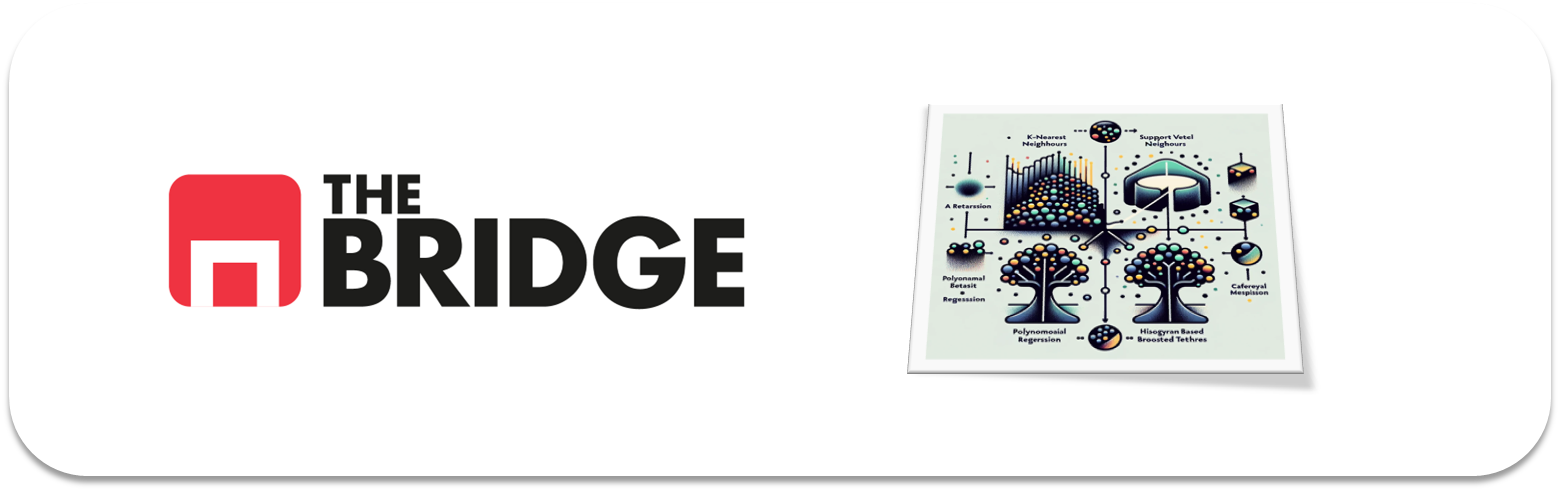

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, make_scorer, recall_score, confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import bootcampviztools as bt
import toolbox_ML

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

# 1. Clasificación de la Calidad del Vino (Problema de Clasificación)

## Descripción del problema:
- La **variable objetivo** es la calidad del vino, que tiene valores discretos entre 0 y 10.
- El objetivo es predecir la clase de calidad de un vino basándonos en las características fisicoquímicas disponibles, como acidez, densidad, etc.
- Este es un problema de clasificación **multiclase**.

## Distribución de la calidad:
- La distribución de las clases puede estar desbalanceada. Por ejemplo, si la mayoría de los vinos tienen una calidad entre 5 y 7, entonces las clases extremas (calidad 0-4 y 8-10) pueden tener menos ejemplos.
- Este desbalance podría afectar a los modelos, ya que tenderán a predecir más las clases más comunes.
- **Recall** (sensibilidad) es una métrica adecuada para medir el desempeño del modelo en este caso, ya que el negocio está interesado en clasificar correctamente todas las clases, especialmente aquellas menos representadas.

## Soluciones posibles:
- **Baseline con KNN**: útil para establecer un punto de partida en la clasificación.
- Modelos más avanzados como **Random Forest** y **SVM** pueden aprovechar mejor las relaciones no lineales entre las características para mejorar el recall.
- Técnicas como **estratificación** y **balanceo de clases** (mediante oversampling o under-sampling) pueden ayudar a mejorar el rendimiento.

## Evaluación:
- Métrica principal: **Recall macro**, que toma en cuenta el recall de cada clase y lo promedia.
- Utilizaremos validación cruzada para asegurarnos de que los resultados no están sesgados.

---

# 2. Predicción del Grado Alcohólico del Vino (Problema de Regresión)

## Descripción del problema:
- La **variable objetivo** es el contenido de alcohol, que es una variable continua.
- El objetivo es predecir el grado alcohólico a partir de las propiedades fisicoquímicas del vino.

## Distribución del grado alcohólico:
- El grado alcohólico puede variar dentro de un rango específico, lo cual nos lleva a considerar un modelo de regresión.
- El desafío será minimizar los errores de predicción porcentuales. Se puede usar una métrica como el **Error Absoluto Medio (MAE)** o **Error Cuadrático Medio (RMSE)** para evaluar la precisión del modelo.

## Soluciones posibles:
- El baseline podría ser un **modelo de regresión lineal** simple o **k-vecinos cercanos** para regresión.
- Modelos más avanzados como **Random Forest** o **Gradient Boosting** pueden ser útiles para capturar patrones más complejos.

## Evaluación:
- Métrica principal: **MAE o RMSE**, que mide el error en las predicciones de alcohol.
- Técnicas como la **optimización de hiperparámetros** pueden afinar los modelos para minimizar el error.

---

In [3]:
df_vino = pd.read_csv("./data/wines_dataset.csv", sep="|")

In [4]:
df_vino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


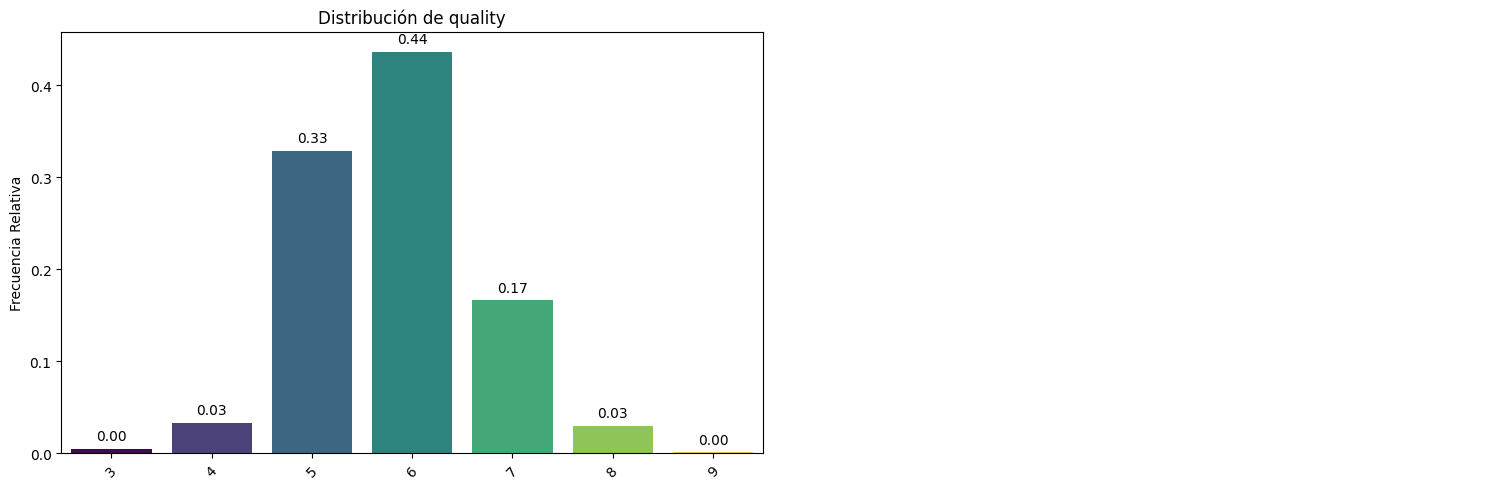

In [5]:
bt.pinta_distribucion_categoricas(df_vino,["quality"], relativa=True, mostrar_valores=True)

<Axes: xlabel='alcohol', ylabel='Count'>

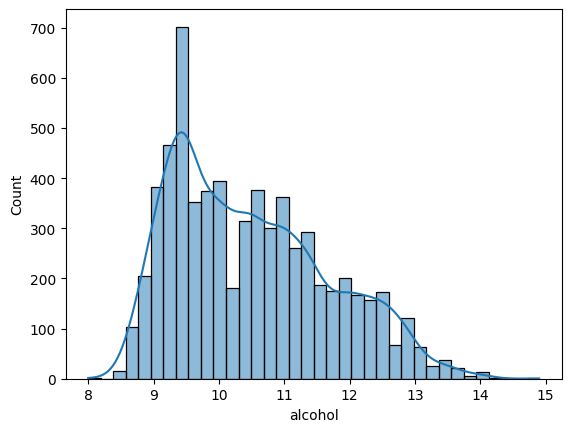

In [6]:
sns.histplot(x = "alcohol", data = df_vino, kde = True)


In [7]:
toolbox_ML.describe_df(df_vino)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
Tipo de Dato,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object
% Valores Nulos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valores Únicos,106,187,89,316,214,135,276,998,108,111,111,7,2
% Cardinalidad,1.63,2.88,1.37,4.86,3.29,2.08,4.25,15.36,1.66,1.71,1.71,0.11,0.03


In [8]:
df_vino["quality"].value_counts().nunique()

7

In [9]:
df_vino.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red


In [10]:
target_cat = "quality"
target_reg = "alcohol"

In [11]:
toolbox_ML.tipifica_variables(df_vino, 12, 0.90)

,nombre_variable,tipo_sugerido
0,fixed acidity,Numerica Continua
1,volatile acidity,Numerica Continua
2,citric acid,Numerica Continua
3,residual sugar,Numerica Continua
4,chlorides,Numerica Continua
5,free sulfur dioxide,Numerica Continua
6,total sulfur dioxide,Numerica Continua
7,density,Numerica Continua
8,pH,Numerica Continua
9,sulphates,Numerica Continua


### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

In [26]:
'''
Mini Eda

Variables Numericas
'''

features_num = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]
features_cat = ["class"]

train_set, test_set = train_test_split(df_vino, test_size=0.20, stratify=df_vino["quality"])

X_train = train_set.drop(target_cat, axis = 1)
y_train = train_set[target_cat]
X_test = test_set.drop(target_cat, axis = 1)
y_test = test_set[target_cat]

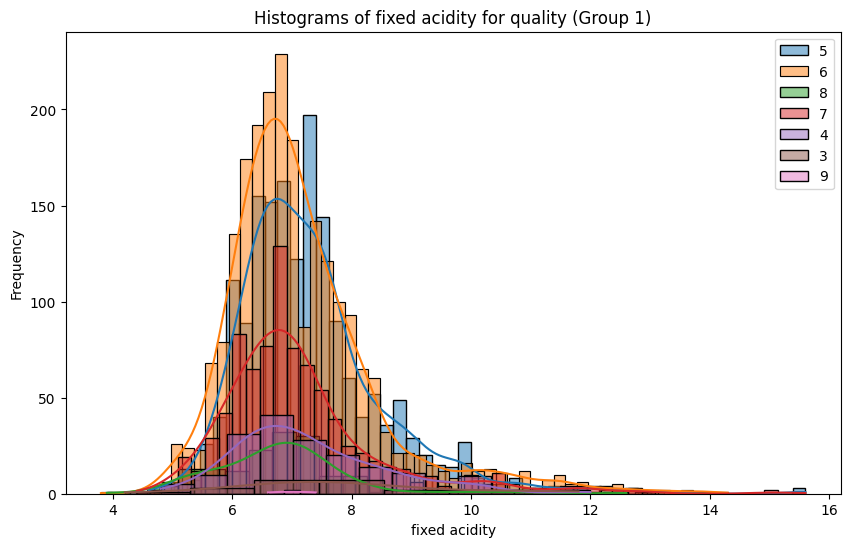

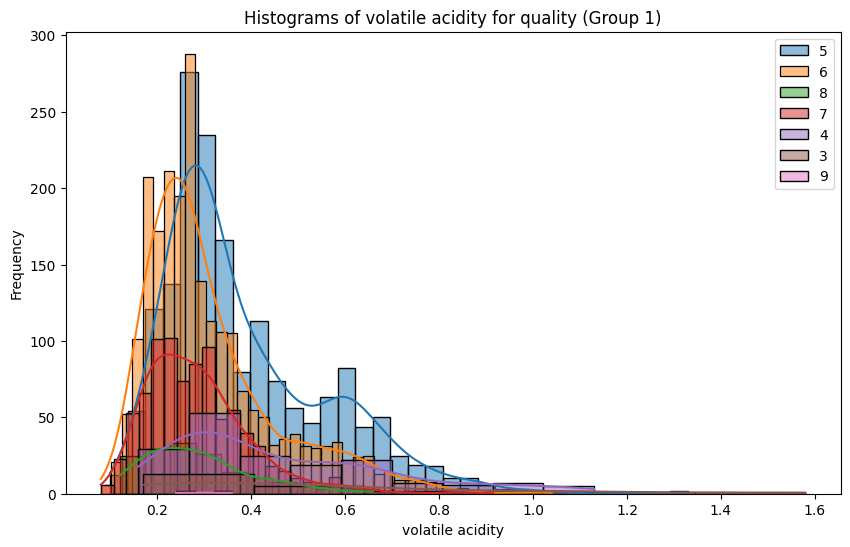

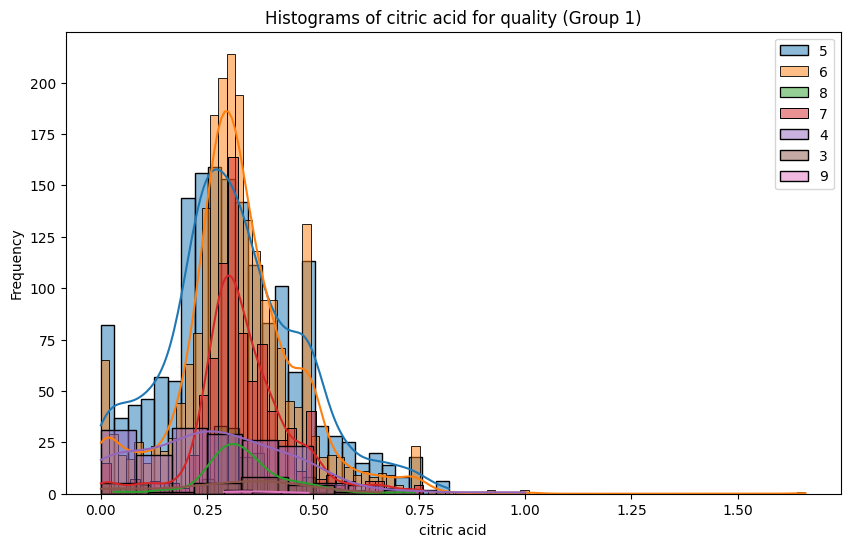

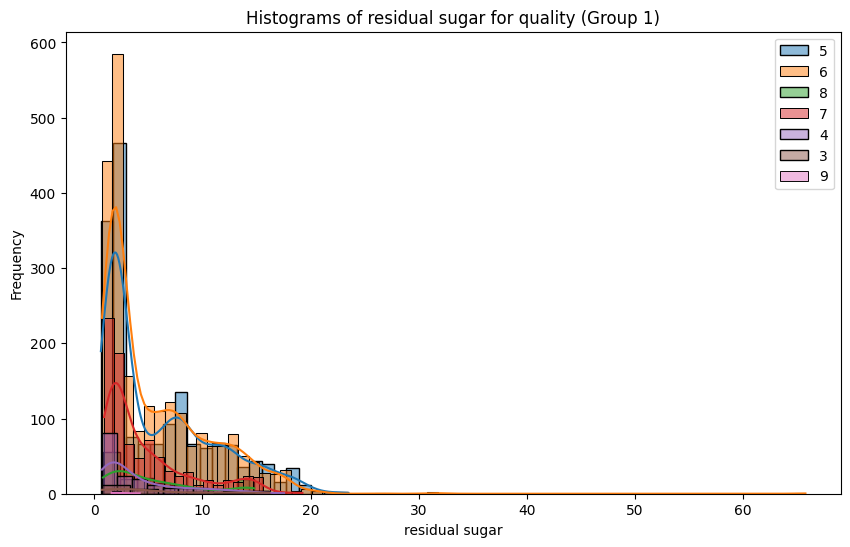

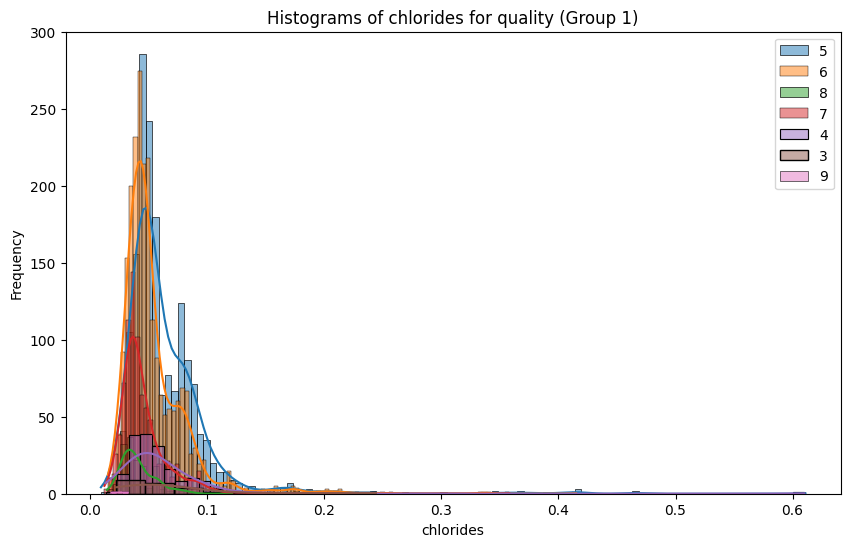

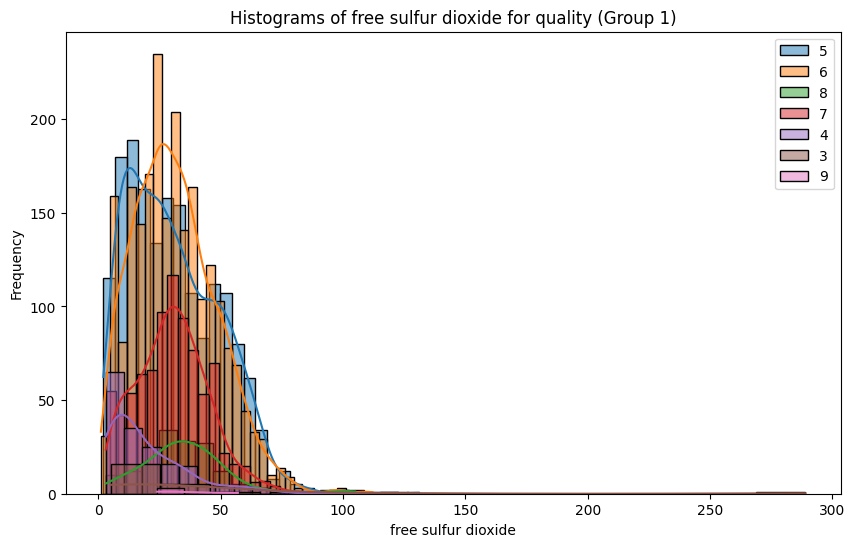

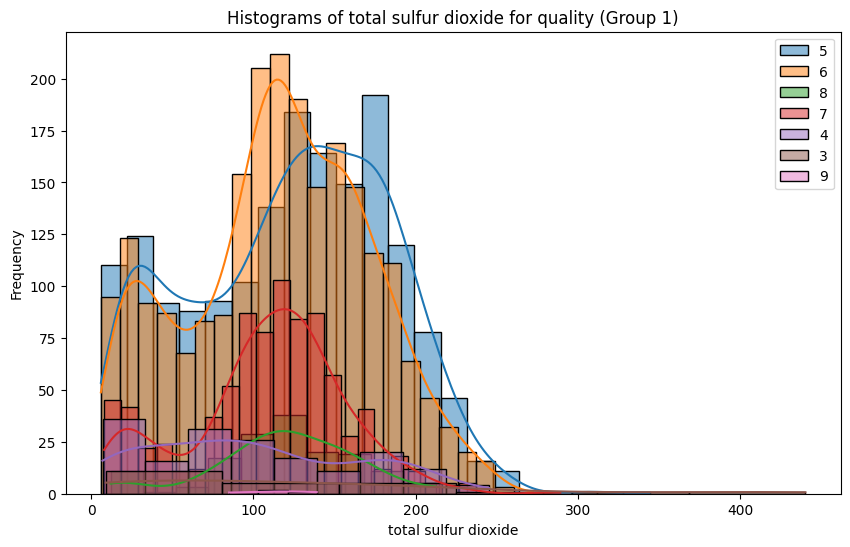

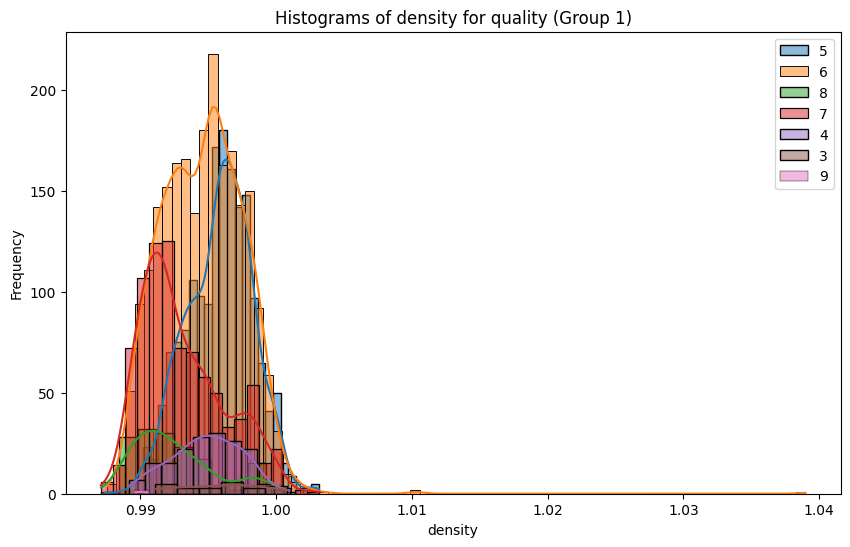

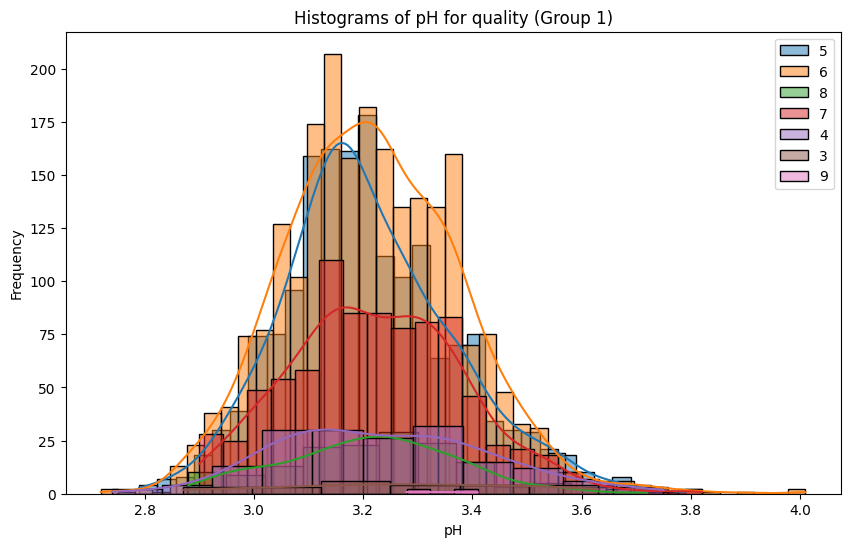

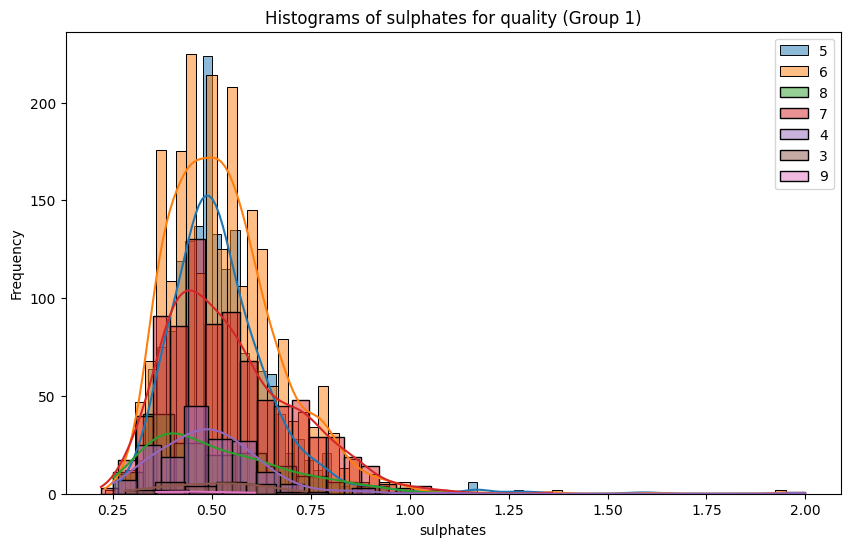

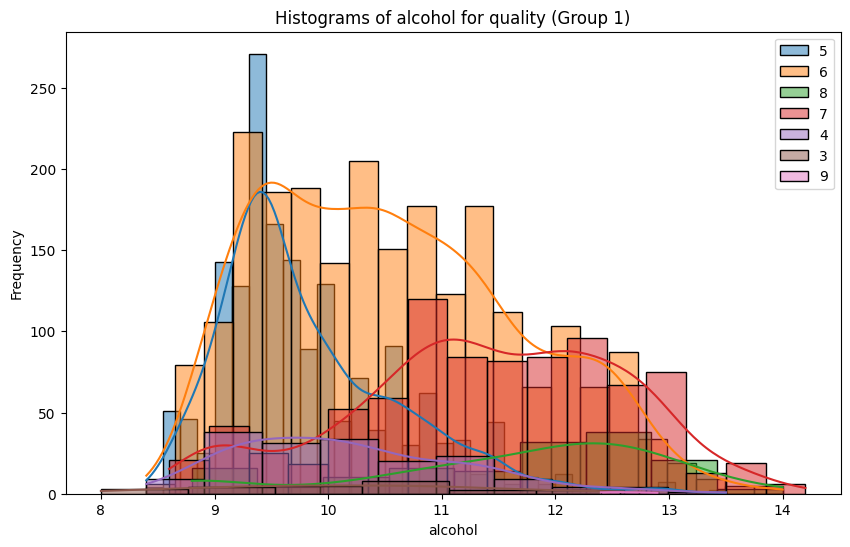

In [27]:
for col in features_num:
    bt.plot_grouped_histograms(train_set, target_cat, col, group_size=10)

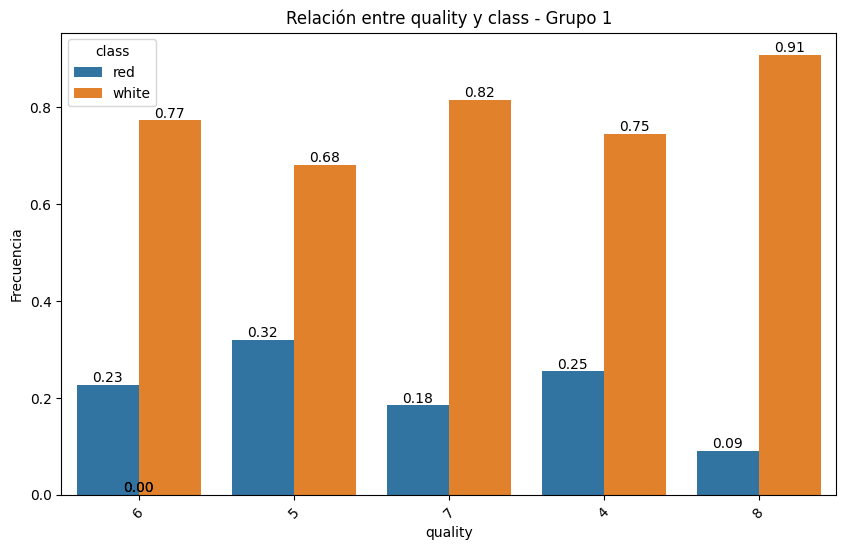

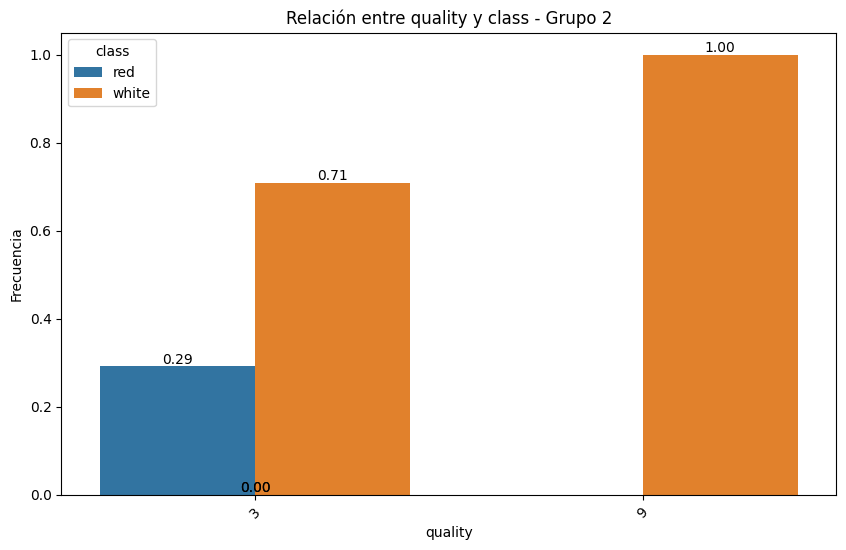

In [47]:
'''
Ahora la variable Categorica Binaria
'''

for col in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target_cat, col, show_values= True, relative_freq= True)

In [28]:
features_num = ["volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"]
features_cat = ["class"]

In [29]:
features = features_cat + features_num

In [30]:
"""
Empiezo mi modelo, ya me quedo con todas las variables
"""

scaler = StandardScaler()
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

ordinal_encoder = OrdinalEncoder()
X_train[features_cat] = ordinal_encoder.fit_transform(X_train[features_cat])
X_test[features_cat] = ordinal_encoder.transform(X_test[features_cat])


array([[<Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>],
       [<Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>],
       [<Axes: title={'center': 'alcohol'}>, <Axes: >, <Axes: >]],
      dtype=object)

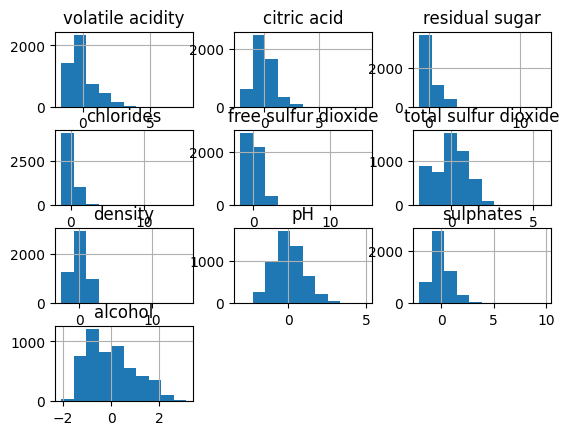

In [31]:
X_train[features_num].hist()

<Axes: >

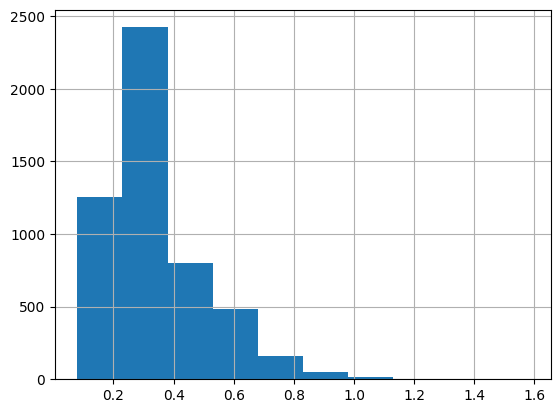

In [32]:
train_set["volatile acidity"].hist()

In [33]:
for col in features_num:
    train_set[col] = np.sqrt(train_set[col]+1)
    test_set[col] = np.sqrt(test_set[col]+1)

array([[<Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>,
        <Axes: title={'center': 'residual sugar'}>],
       [<Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>,
        <Axes: title={'center': 'total sulfur dioxide'}>],
       [<Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>],
       [<Axes: title={'center': 'alcohol'}>, <Axes: >, <Axes: >]],
      dtype=object)

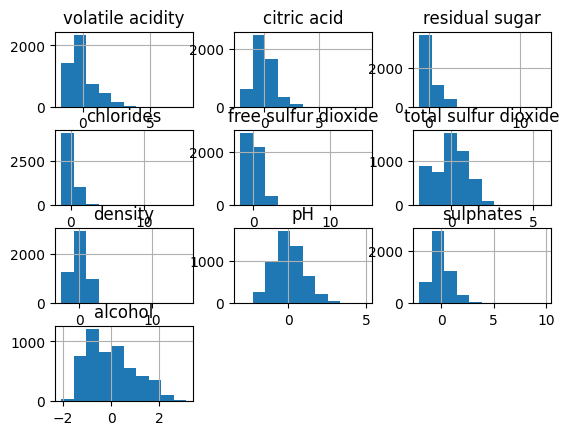

In [34]:
X_train[features_num].hist()

In [35]:
df_vino["quality"].value_counts(True)

quality
6    0.436509
5    0.329075
7    0.166077
4    0.033246
8    0.029706
3    0.004618
9    0.000770
Name: proportion, dtype: float64

In [36]:
'''
Balanceo el Target_cat que estaba desbalanceado
'''

smote = SMOTE(k_neighbors=3,random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [37]:
train_set["quality"].value_counts(True)

quality
6    0.436598
5    0.329036
7    0.166057
4    0.033288
8    0.029632
3    0.004618
9    0.000770
Name: proportion, dtype: float64

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score



# Definir el modelo baseline: KNN Clasificación
knn = KNeighborsClassifier()

# Definir el modelo Random Forest, usando class_weight="balanced" para manejar clases desbalanceadas
rf_clf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Definir el modelo Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state=42, subsample=0.8)

# Definir Balanced Accuracy como métrica de scoring para la optimización
scorer_balanced_accuracy = make_scorer(balanced_accuracy_score)

# Validación cruzada de KNN
knn_cv_score = cross_val_score(knn, X_train[features], y_train, cv=5, scoring=scorer_balanced_accuracy)

# Validación cruzada de Random Forest
rf_cv_score = cross_val_score(rf_clf, X_train[features], y_train, cv=5, scoring=scorer_balanced_accuracy)

# Validación cruzada de Gradient Boosting
gb_cv_score = cross_val_score(gb_clf, X_train[features], y_train, cv=5, scoring=scorer_balanced_accuracy)

# Optimización de hiperparámetros para Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],        # Número de árboles
    'learning_rate': [0.01, 0.05, 0.1],    # Tasa de aprendizaje
    'max_depth': [3, 5, 7],                # Profundidad máxima de los árboles
    'subsample': [0.6, 0.8, 1.0],          # Submuestreo de los datos
    'min_samples_split': [2, 5, 10]        # Muestras mínimas necesarias para dividir un nodo
}

grid_search_gb = GridSearchCV(gb_clf, param_grid_gb, cv=5, scoring=scorer_balanced_accuracy)
grid_search_gb.fit(X_train[features], y_train)

# Optimización de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],            # Número de árboles en el bosque
    'max_depth': [10, 20, 30, 50]          # Profundidad máxima del árbol
}

grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5, scoring=scorer_balanced_accuracy)
grid_search_rf.fit(X_train[features], y_train)

# Obtener los resultados
print("Balanced Accuracy - KNN:", knn_cv_score.mean())  # Balanced Accuracy promedio para KNN
print("Balanced Accuracy - Random Forest:", rf_cv_score.mean())  # Balanced Accuracy promedio para Random Forest
print("Balanced Accuracy - Gradient Boosting:", gb_cv_score.mean())  # Balanced Accuracy promedio para Gradient Boosting

# Resultados optimizados de Random Forest
print("Mejor Balanced Accuracy (Random Forest Optimizado):", grid_search_rf.best_score_)
print("Mejores hiperparámetros para Random Forest:", grid_search_rf.best_params_)

# Resultados optimizados de Gradient Boosting
print("Mejor Balanced Accuracy (Gradient Boosting Optimizado):", grid_search_gb.best_score_)
print("Mejores hiperparámetros para Gradient Boosting:", grid_search_gb.best_params_)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-package

In [ ]:
# Evaluar los modelos optimizados en el conjunto de test
from sklearn.metrics import classification_report, balanced_accuracy_score

# Usar el mejor modelo de Random Forest encontrado por GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

# Usar el mejor modelo de Gradient Boosting encontrado por GridSearchCV
best_gb_model = grid_search_gb.best_estimator_

# Predecir con el modelo KNN (baseline)
knn.fit(X_train[features], y_train)  # Entrenamos el modelo KNN completo
y_pred_knn = knn.predict(X_test[features])

# Predecir con el mejor modelo de Random Forest optimizado
y_pred_rf = best_rf_model.predict(X_test[features])

# Predecir con el mejor modelo de Gradient Boosting optimizado
y_pred_gb = best_gb_model.predict(X_test[features])

# Evaluar Balanced Accuracy para cada modelo en el conjunto de prueba
knn_test_score = balanced_accuracy_score(y_test, y_pred_knn)
rf_test_score = balanced_accuracy_score(y_test, y_pred_rf)
gb_test_score = balanced_accuracy_score(y_test, y_pred_gb)

print("Balanced Accuracy en Test - KNN (baseline):", knn_test_score)
print("Balanced Accuracy en Test - Random Forest (optimizado):", rf_test_score)
print("Balanced Accuracy en Test - Gradient Boosting (optimizado):", gb_test_score)

# Reporte de clasificación detallado para entender precisión, recall, f1-score, etc.
print("\nReporte de clasificación para KNN (baseline):\n", classification_report(y_test, y_pred_knn))
print("Reporte de clasificación para Random Forest (optimizado):\n", classification_report(y_test, y_pred_rf))
print("Reporte de clasificación para Gradient Boosting (optimizado):\n", classification_report(y_test, y_pred_gb))

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [13]:
'''
Mini Eda

Variables Numericas
'''

features_num = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates"]
features_cat = ["class", "quality"]

train_set, test_set = train_test_split(df_vino, test_size=0.20, stratify=df_vino["quality"])

X_train = train_set.drop(target_reg, axis = 1)
y_train = train_set[target_reg]
X_test = test_set.drop(target_reg, axis = 1)
y_test = test_set[target_reg]

In [14]:
corr_matrix = train_set.corr(numeric_only= True)
corr_matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.220601,0.315991,-0.119477,0.298059,-0.285892,-0.333808,0.452871,-0.250927,0.304753,-0.090941,-0.086214
volatile acidity,0.220601,1.000000,-0.378808,-0.196298,0.378761,-0.356805,-0.414445,0.263266,0.254971,0.227551,-0.029920,-0.255158
citric acid,0.315991,-0.378808,1.000000,0.128742,0.041241,0.135372,0.194442,0.089650,-0.323561,0.066935,-0.011834,0.084116
residual sugar,-0.119477,-0.196298,0.128742,1.000000,-0.129886,0.399400,0.491641,0.558679,-0.266284,-0.182626,-0.362977,-0.042876
chlorides,0.298059,0.378761,0.041241,-0.129886,1.000000,-0.186412,-0.274047,0.352288,0.031083,0.397097,-0.254588,-0.203461
free sulfur dioxide,-0.285892,-0.356805,0.135372,0.399400,-0.186412,1.000000,0.720703,0.025383,-0.147556,-0.187150,-0.181147,0.052938
total sulfur dioxide,-0.333808,-0.414445,0.194442,0.491641,-0.274047,0.720703,1.000000,0.030524,-0.242513,-0.272560,-0.264733,-0.040849
density,0.452871,0.263266,0.089650,0.558679,0.352288,0.025383,0.030524,1.000000,0.006187,0.254643,-0.683991,-0.310160
pH,-0.250927,0.254971,-0.323561,-0.266284,0.031083,-0.147556,-0.242513,0.006187,1.000000,0.186680,0.126540,0.029214
sulphates,0.304753,0.227551,0.066935,-0.182626,0.397097,-0.187150,-0.272560,0.254643,0.186680,1.000000,0.008750,0.042179


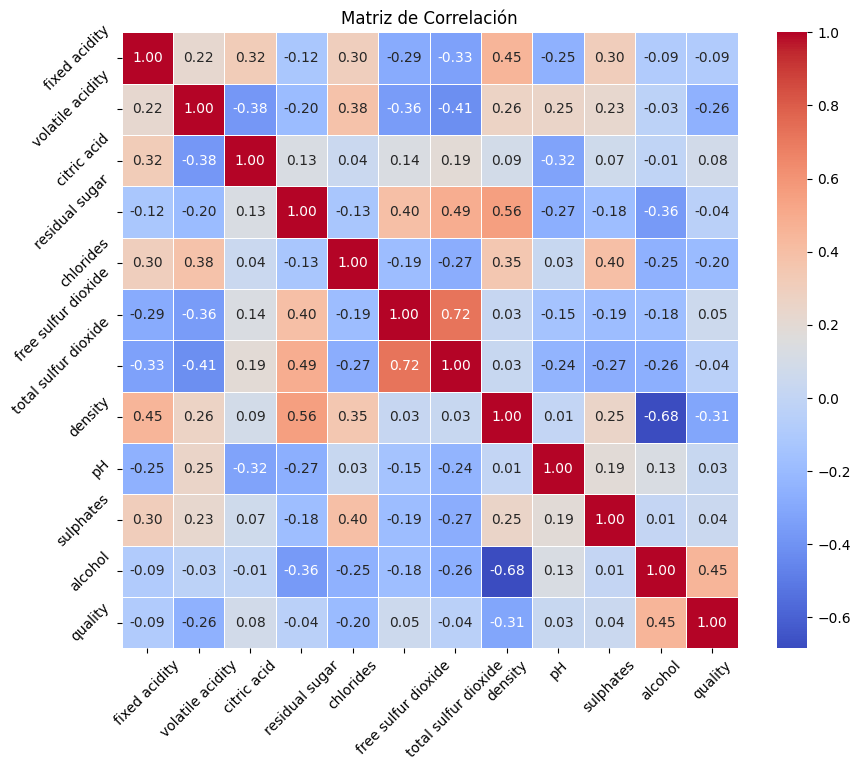

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            cbar=True, square=True, linewidths=.5)

plt.title('Matriz de Correlación')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [16]:

features_num = ["residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH"]
features_cat = ["quality"]

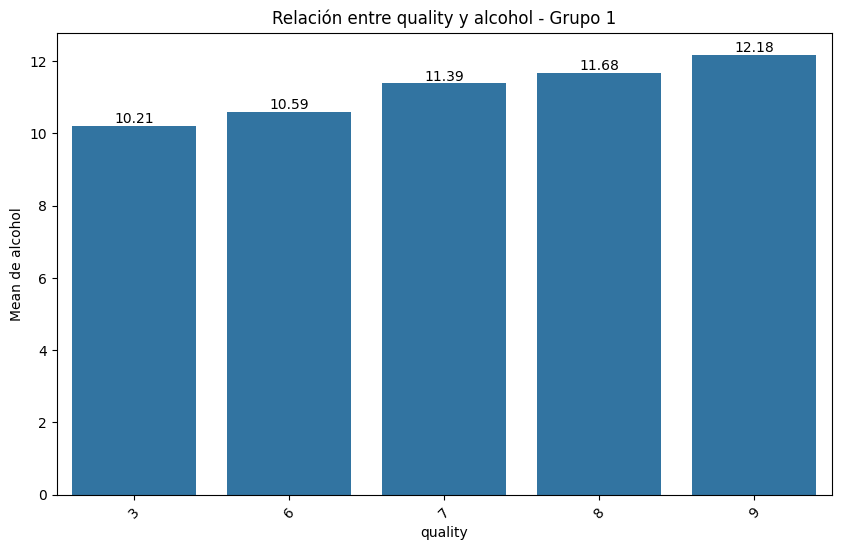

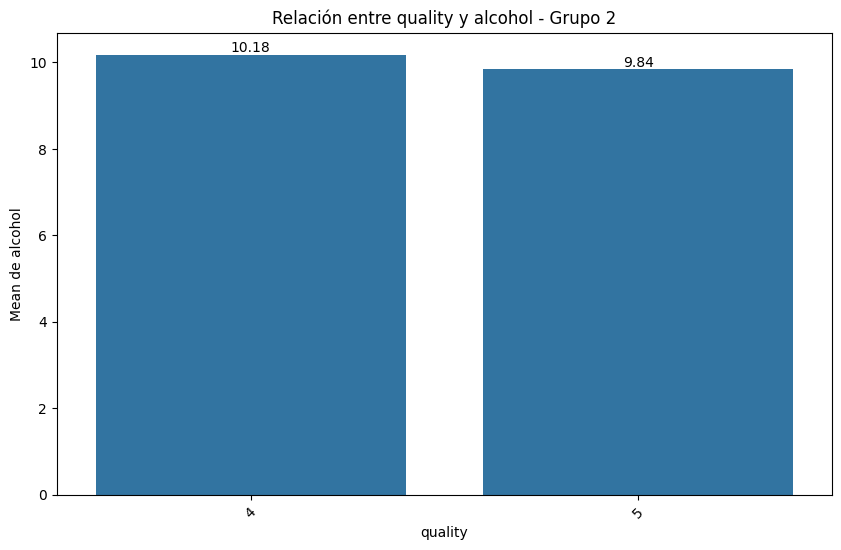

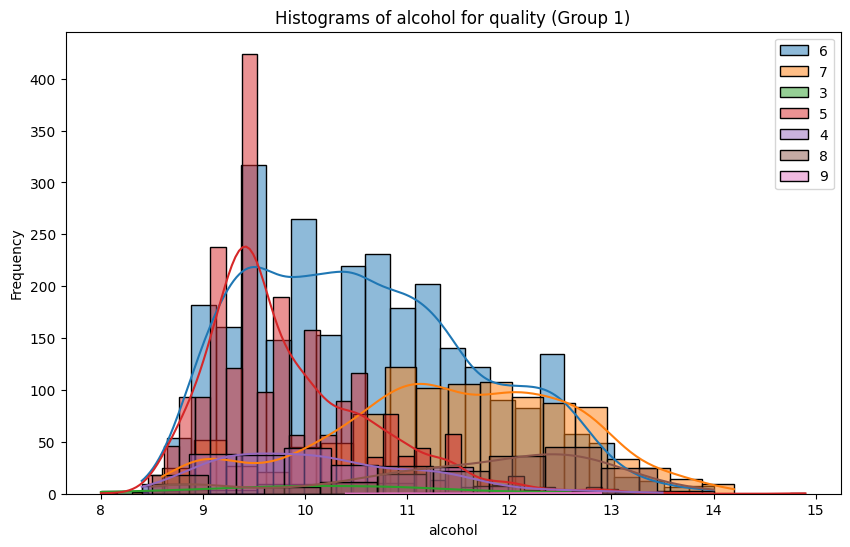

In [17]:
for col in features_cat:
    bt.plot_categorical_numerical_relationship(df_vino, col, target_reg,show_values=True)
    bt.plot_grouped_histograms(df_vino, col, target_reg, group_size=10)

In [18]:

features_num = ["residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","quality"]
features_cat = []
features= features_cat+features_num

In [19]:

scaler = StandardScaler()
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# Definir RMSE
scorer_rmse = make_scorer(mean_squared_error, squared=False)

# Optimización de hiperparámetros para Ridge (Regresión Lineal Regularizada)
ridge = Ridge()

param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}  # valores de regularización para Ridge
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring=scorer_rmse)
grid_search_ridge.fit(X_train[features], y_train)

# Optimización de hiperparámetros para Random Forest
rf_reg = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],           # Número de árboles
    'max_depth': [10, 20, 30],                 # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],           # Muestras mínimas para hacer split
    'max_features': ['auto', 'sqrt', 'log2']   # Número de características a considerar
}
grid_search_rf = GridSearchCV(rf_reg, param_grid_rf, cv=5, scoring=scorer_rmse)
grid_search_rf.fit(X_train[features], y_train)

# Optimización de hiperparámetros para Gradient Boosting (ya lo teníamos definido)
param_grid_gbr = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7]}
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gbr, cv=5, scoring=scorer_rmse)
grid_search_gbr.fit(X_train[features], y_train)

# Obtener los mejores resultados para cada modelo
print("Best Ridge RMSE (Optimized):", grid_search_ridge.best_score_)
print("Best Parameters for Ridge:", grid_search_ridge.best_params_)

print("Best Random Forest RMSE (Optimized):", grid_search_rf.best_score_)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

print("Best Gradient Boosting RMSE (Optimized):", grid_search_gbr.best_score_)
print("Best Parameters for Gradient Boosting:", grid_search_gbr.best_params_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

Best Ridge RMSE (Optimized): 0.7216149204543567
Best Parameters for Ridge: {'alpha': 100}
Best Random Forest RMSE (Optimized): 0.563322534891863
Best Parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Best Gradient Boosting RMSE (Optimized): 0.793871369204113
Best Parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [25]:
# Predecir los valores de alcohol en el conjunto de prueba con el mejor modelo (Gradient Boosting Optimizado)
y_pred = grid_search_gbr.best_estimator_.predict(X_test[features])

# Calcular el RMSE en el conjunto de prueba
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE en el conjunto de prueba:", rmse_test)

# Mostrar algunos errores de predicción
errores = pd.DataFrame({'Real': y_test, 'Predicho': y_pred, 'Error': y_test - y_pred})
print(errores.head())

RMSE en el conjunto de prueba: 0.7547817614541509
      Real   Predicho     Error
4762  10.9  11.165929 -0.265929
371   10.2  10.306658 -0.106658
752    9.1  10.185134 -1.085134
557   10.8  10.595669  0.204331
3822  11.4  11.198521  0.201479


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
